Let's import all libraries and define functions for later use:

In [105]:
import os
import matplotlib.pyplot as plt

from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph

from langchain_community.llms import HuggingFaceEndpoint
from langchain_community.chat_models.huggingface import ChatHuggingFace


def get_graph_docs(text,llm):
    documents = [Document(page_content=text)]
    llm_transformer = LLMGraphTransformer(llm=llm
                                        #    allowed_nodes=["Person", "Country", "Organization"],
                                        #    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
                                        )
    graph_documents = llm_transformer.convert_to_graph_documents(documents)
    graph = NetworkxEntityGraph()
    for node in graph_documents[0].nodes:
        graph.add_node(node.id)
    for edge in graph_documents[0].relationships:
        graph._graph.add_edge(
                edge.source.id,
                edge.target.id,
                relation=edge.type,
            )
    return graph

def plot_knowledge_graph(entity_graph,pngname='Graph.png'):
    G = entity_graph._graph
    pos = nx.spring_layout(G)  
    fig=plt.figure(figsize=(12, 8)) 
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    fig.savefig(pngname,dpi=200)
    plt.show()


Let's use a simple text:

In [106]:
text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris. 
"""

At first, we have to extract the knowledge graph from the text. The model zephyr-7b-beta worked better for me.

In [107]:
key_file='../../LM_Tests/huggingfacehub_api_token.txt'
with open(key_file, 'r') as file:
   api_key=file.read()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = api_key
llm = ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id="HuggingFaceH4/zephyr-7b-beta"))   

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/acrnjar/.cache/huggingface/token
Login successful


/home/acrnjar/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Extract knowledge graph, and print out edge triplets (source node, target node, and relation):

In [108]:
graph=get_graph_docs(text,llm)
graph.get_triples()

[('Pierre Curie', 'Marie Curie', 'CO_WON_NOBEL_PRIZE'),
 ('Marie Curie', '1867', 'BORN'),
 ('Marie Curie', '1st Nobel Prize', 'WON_NOBEL_PRIZE'),
 ('Marie Curie', '2nd Nobel Prize', 'WON_NOBEL_PRIZE'),
 ('Marie Curie', 'Pierre Curie', 'HUSBAND_OF'),
 ('Marie Curie',
  'to become a professor at the University of Paris',
  'FIRST_WOMAN')]

Plot the knowledge graph:

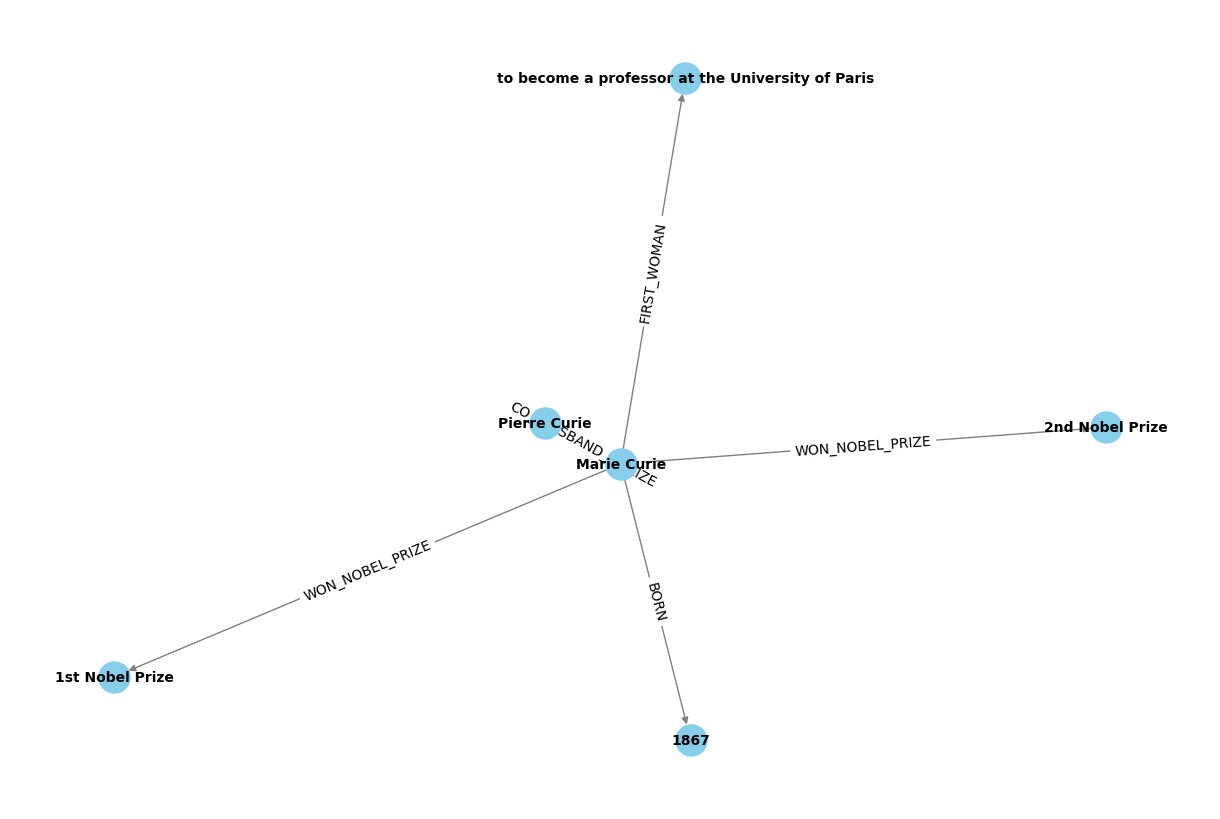

In [111]:

plot_knowledge_graph(graph)

Finally, let's perform Question Answering task. Here, OpenAI model worked better.

In [110]:
llm2=OpenAI(temperature=0)
chain = GraphQAChain.from_llm(
    llm=llm2,
    graph=graph, 
    verbose=True
)
question = "Who is Marie Curie?"
answer=chain.run(question)
print(f"{answer=}")




> Entering new GraphQAChain chain...
Entities Extracted:
 Marie Curie
Full Context:
Marie Curie BORN 1867
Marie Curie WON_NOBEL_PRIZE 1st Nobel Prize
Marie Curie WON_NOBEL_PRIZE 2nd Nobel Prize
Marie Curie HUSBAND_OF Pierre Curie
Marie Curie FIRST_WOMAN to become a professor at the University of Paris

> Finished chain.
answer='\nMarie Curie was a female scientist who was born in 1867. She was the first woman to become a professor at the University of Paris and was married to Pierre Curie. She also won two Nobel Prizes during her lifetime.'
